In [531]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import pandas as pd
from astropy import constants as cn, units as un
import sympy as sp
sp.init_printing()
%matplotlib inline

# Week 4 Notes
### More advanced function fitting, useful tricks for physics calculations

## Fitting

Last week we saw how to fit some basic functions using the scipy leastsq fit. In the problem set you got to fit something a bit more complicated. We will still use a least squares fit, since more advanced fitting methods such as Markov Chain Monte Carlo methods are beyond the scope of this seminar, but I hope to show you how to effectively use the scipy model as well as what it's limitations are. 

First we need to read the data from the data file. For this we will use pandas, a scientific library for reading data from various different file formats. Today we need to read data from a CSV file.

In [528]:
df = pd.read_csv("Week_4_data.csv")
df.head()

,x,y,yerr
0,0.000000,-0.057109,0.002000
1,0.161107,1.083873,0.204187
2,0.322215,1.406260,0.290397
3,0.483322,1.187659,0.229809
4,0.644429,0.252675,0.065119


In [529]:
x = df['x']
y = df['y']
y_err = df['yerr']

array([ 1.61869526e+00, -3.06079500e-01,  4.49709965e+00,  2.80422445e-03])

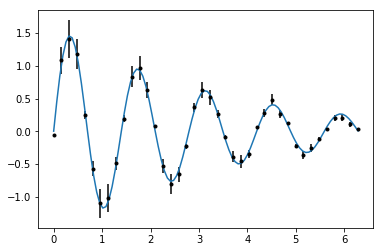

In [530]:
def fit_func(p, x):
    return p[0] * np.exp(p[1] * x) * np.sin(p[2] * x) + p[3]

def err_func(p, x, y):
    return y - fit_func(p, x)

# First try with [1., 1., 1., 1.] -> It is not very good
p0 = [1.5, 0.5, 5., 0.]
p1, success = leastsq(err_func, p0[:], args=(x, y))

x_ft = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots()
ax.plot(x_ft, fit_func(p1, x_ft))
ax.errorbar(x, y, yerr=y_err, fmt='.', color='k')
p1

Now let's see how we can analyze the error on this. Our error function allows us to easily do this.

There are two different error measurements we can look at. The first one is the average of the sum of the error itself:

$$ \frac{1}{n} \sum_{i = 1}^n \text{e}_i $$

The second is the average of the square of the errors, or the RMS error:

$$ \sqrt{\frac{1}{n} \sum_{i = 1}^n \text{e}_i^2} $$

Here $e_i = y_i - f(x_i)$ where $f(x_i)$ where the data point is $(x_i, y_i)$ and $f(x_i)$ is the result of the fit function evaluated at the $x$ value associated with $y_i$. We have already coded this in the form of our error function.

Usually, the latter is the more useful one to cite and it is this error that is minimized in the least squares fit. But let's calculate both anyways.

In [356]:
# Cmpute the error (with a for loop)
def calc_err(err_func, p, x, y):
    err = 0.
    err2 = 0.

    for i in range(len(x)):
        err += err_func(p1, x[i], y[i])
        err2 += err_func(p1, x[i], y[i]) ** 2
    
    err = err/len(x)
    rms_err = np.sqrt(err2/len(x))
    
    return err, rms_err

In [357]:
err, rms = calc_err(err_func, p1, x, y)

In [358]:
# The values of the errors
err, rms

In [359]:
# The percent RMS error
rms * 100

In [360]:
# Cleaner way to compute the error using numpy features. Same RMS error as we did above.
err = err_func(p1, x, y)
np.sqrt(np.sum(err**2) / len(err))

In general, least square fits are great for data that can be fit by function that are either monatomic or polynomial. They are also pretty good at simple sinusoidal functions but more complicated functions such as the damped oscillator above require some intuition about what the values should be.

If you take a course on advanced scientific computing or read any textbook on the topic, you will find more robust fitting methods that may be better suited to this problem.

## Useful Features for Physics Calculations

We will use Astropy module to perform calculations with units and constants.

The first useful feature is constants. Most physical constants can be used and converted between units. We will look at unit conversions shortly, but first I will just show you a couple constans 

In [524]:
dir(cn)

['Constant',
 'EMConstant',
 'G',
 'GM_earth',
 'GM_jup',
 'GM_sun',
 'L_bol0',
 'L_sun',
 'M_earth',
 'M_jup',
 'M_sun',
 'N_A',
 'R',
 'R_earth',
 'R_jup',
 'R_sun',
 'Ryd',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'a0',
 'alpha',
 'atm',
 'au',
 'b_wien',
 'c',
 'cgs',
 'codata2014',
 'constant',
 'e',
 'eps0',
 'g0',
 'h',
 'hbar',
 'iau2015',
 'k_B',
 'kpc',
 'm_e',
 'm_n',
 'm_p',
 'mu0',
 'muB',
 'pc',
 'set_enabled_constants',
 'si',
 'sigma_T',
 'sigma_sb',
 'u',
 'utils']

In [525]:
cn.hbar

<<class 'astropy.constants.codata2014.CODATA2014'> name='Reduced Planck constant' value=1.0545718e-34 uncertainty=1.3e-42 unit='J s' reference='CODATA 2014'>

In [169]:
cn.G

<<class 'astropy.constants.codata2014.CODATA2014'> name='Gravitational constant' value=6.67408e-11 uncertainty=3.1e-15 unit='m3 / (kg s2)' reference='CODATA 2014'>

We can also create quantities that have units. For example, let's define two lines, one with length 3.2m and the other 43.7cm.

In [173]:
l1 = 3.2 * un.m
l1

<Quantity 3.2 m>

In [175]:
l2 = 43.7 * un.cm
l2

<Quantity 43.7 cm>

Now we can add them together and the units will still be correct.

In [183]:
l1 + l2

<Quantity 3.637 m>

No conversion necessary on our part and we clearly see what the units are. Now let's say we want to convert the units. For example, let's convert l2 to m.

In [184]:
l2 = l2.to(un.m)
l2

<Quantity 0.437 m>

We can also do more complicted unit conversion using strings. 

In [191]:
cn.G.to("cm3 / g s2")

<Quantity 6.67408e-08 cm3 / (g s2)>

In [192]:
cn.G.to("km3 / kg s2")

<Quantity 6.67408e-20 km3 / (kg s2)>

Which are 2 other common units for the gravitational constant. Sometimes we want to do conversions between really standard unit conventions. For example, astronomers typicall use cgs (centimeters, grams, second) so we might want to convert our constants to that. We did it above for G but there is an easier way:

In [216]:
G = cn.G.cgs
G

<Quantity 6.67408e-08 cm3 / (g s2)>

And we can convert it back to SI in the same way:

In [218]:
G = G.si
G

<Quantity 6.67408e-11 m3 / (kg s2)>

Now let's see how this can help us for a calculation. We will use the formula for Newtonian gravity to calculate the acceleration at the surface of the earth. 

$$ a = -\frac{GM}{r^2} $$

We will need:
1. Mass of the earth
2. G
3. Radius of the earth

In [224]:
Me = cn.M_earth
G = cn.G
Re = cn.R_earth

In [225]:
Me

<<class 'astropy.constants.iau2015.IAU2015'> name='Earth mass' value=5.972364730419773e+24 uncertainty=2.7740648395436216e+20 unit='kg' reference='IAU 2015 Resolution B 3 + CODATA 2014'>

In [226]:
G

<<class 'astropy.constants.codata2014.CODATA2014'> name='Gravitational constant' value=6.67408e-11 uncertainty=3.1e-15 unit='m3 / (kg s2)' reference='CODATA 2014'>

In [227]:
Re

<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal Earth equatorial radius' value=6378100.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>

So let's try performaing the calculation and then checking the units.

In [229]:
a = - (G * Me) / Re**2
a

<Quantity -9.79839813 m / s2>

And we can also see just the units if we want:

In [234]:
a.unit

Unit("m / s2")

Which are indeed the correct units of acceleration. We also notice the value is what we expect. Let's try it now with different units to check it still works.

In [249]:
Re = Re.to(un.km)
Me = Me.cgs

In [250]:
Re

<Quantity 6378.1 km>

In [251]:
Me

<Quantity 5.97236473e+27 g>

In [252]:
a = - (G * Me) / Re**2
a

<Quantity -9.79839813e+09 g m3 / (kg km2 s2)>

Now we have weird composite units that are difficult to read. But that's no problem, because we can easily convert it. If we want it in SI we can do either:

In [256]:
a.si

<Quantity -9.79839813 m / s2>

In [257]:
a.to("m / s2")

<Quantity -9.79839813 m / s2>

And we get back exactly what we expected. 

Using units can be helpful both in terms of converting things and also to make sure the dimensions are correct. You will immediately know with confidence that your calculations at least have the right combinations of quantitites which can avoid many simple calculation errors. 

Another useful package for physics is the Sympy package. I will not got into too much detail since it is easy for you to read up on it and use the methods but I will show you some basic features such as analytic integrals and derivatives.

In [261]:
# Now create som symbolic variables
x, y, z = sp.symbols('x, y, z')

We can use the symbols we defined to create an algebraic formula.

In [265]:
a = x * y / z
a

We can also substitute values into that formula to get a numerical result.

In [273]:
a.subs([(x, 1), (y, 2), (z, 4)])

We can define a function with functions such as sin and cos as well:

In [277]:
f = sp.sin(x) * sp.cos(x)**2
f

Let's try taking the derivative and integral of this:

In [283]:
# Algebraic derivative
sp.diff(f, x)

In [287]:
# Derivative evaluated at a point
sp.diff(f, x).subs(x, 2*np.pi)

In [288]:
# Second derivative
sp.diff(f, x, 2)

We can also perform definite and indefinite integrals.

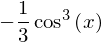

In [290]:
# Indefinite integral
sp.integrate(f, x)

In [292]:
# Definite integral from 0 -> pi
sp.integrate(f, (x, 0, np.pi))

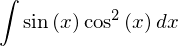

In [301]:
# We can also show the integral before evaluating it
I = sp.Integral(f, x)
I

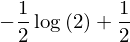

In [333]:
# And then evaluate it once we know we have the right integral
I.doit()

This second way is particularily useful for multivariable integrals

In [313]:
f2 = y/x
f2

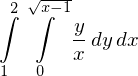

In [319]:
I = sp.Integral(sp.Integral(f2, (y, 0,sp.sqrt(x - 1))), (x, 1, 2))
I

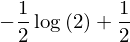

In [482]:
I = I.doit()
I

In [489]:
# We can also evaluate that as a decimal number
I.evalf()

Sympy has many other detailed tutorials and examples for all the functionality on their website. If you want to try it out or do more advanced features then check it out. 

## Some more advanced numpy array examples

Numpy arrays have many features and as you solve problems with Python, you will get to learn many more of them. I will show you some interesting ways of sorting and slecting data.

In [382]:
# We can use reshape to turn a 1d array into a matrix
mat = np.arange(9).reshape(3,3)
mat

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [392]:
# We can select just a column in the same way we would select rows
mat[:,1]

array([1, 4, 7])

In [532]:
mat2 = np.arange(1, 26).reshape(5,5)
mat2

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25]])

In [419]:
# We can slice a portion of it in 2D
mat2[::2,1:3]

array([[ 2,  3],
       [12, 13],
       [22, 23]])

In [459]:
# Let's try an matrix of random numbers and look at sorting it
mat3 = np.random.rand(25).reshape(5,5)
mat3

array([[0.69504878, 0.65449394, 0.55614308, 0.62265516, 0.30344209],
       [0.44589174, 0.37735979, 0.68464581, 0.69953992, 0.9828164 ],
       [0.39673996, 0.04574451, 0.0881544 , 0.62416272, 0.98073203],
       [0.61218114, 0.51112356, 0.52341114, 0.77378067, 0.64066946],
       [0.06721465, 0.17863923, 0.11622641, 0.67156705, 0.16876658]])

In [460]:
# We can sort the rows
np.sort(mat3)

array([[0.30344209, 0.55614308, 0.62265516, 0.65449394, 0.69504878],
       [0.37735979, 0.44589174, 0.68464581, 0.69953992, 0.9828164 ],
       [0.04574451, 0.0881544 , 0.39673996, 0.62416272, 0.98073203],
       [0.51112356, 0.52341114, 0.61218114, 0.64066946, 0.77378067],
       [0.06721465, 0.11622641, 0.16876658, 0.17863923, 0.67156705]])

In [461]:
# Or we can sort the columns
np.sort(mat3, axis=0)

array([[0.06721465, 0.04574451, 0.0881544 , 0.62265516, 0.16876658],
       [0.39673996, 0.17863923, 0.11622641, 0.62416272, 0.30344209],
       [0.44589174, 0.37735979, 0.52341114, 0.67156705, 0.64066946],
       [0.61218114, 0.51112356, 0.55614308, 0.69953992, 0.98073203],
       [0.69504878, 0.65449394, 0.68464581, 0.77378067, 0.9828164 ]])

In [462]:
# To reverse the sort we do the following
np.sort(mat3, axis=0)[::-1]

array([[0.69504878, 0.65449394, 0.68464581, 0.77378067, 0.9828164 ],
       [0.61218114, 0.51112356, 0.55614308, 0.69953992, 0.98073203],
       [0.44589174, 0.37735979, 0.52341114, 0.67156705, 0.64066946],
       [0.39673996, 0.17863923, 0.11622641, 0.62416272, 0.30344209],
       [0.06721465, 0.04574451, 0.0881544 , 0.62265516, 0.16876658]])

In [477]:
# Sort entire matrix by one column
mat3[mat3[:,1].argsort()]

array([[0.39673996, 0.04574451, 0.0881544 , 0.62416272, 0.98073203],
       [0.06721465, 0.17863923, 0.11622641, 0.67156705, 0.16876658],
       [0.44589174, 0.37735979, 0.68464581, 0.69953992, 0.9828164 ],
       [0.61218114, 0.51112356, 0.52341114, 0.77378067, 0.64066946],
       [0.69504878, 0.65449394, 0.55614308, 0.62265516, 0.30344209]])